# MLNS Final Project: Into the Networks of Life
------------------------------------------------------------
### Authors: Dwivedi Deepesh, Giacopelli Nicolò, Liu Dayu, Remadi Adel

# Graph Generation - GraphGAN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.datasets import TUDataset
from layers import GCN, HGPSLPool
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
import numpy as np

In [ ]:
#load data and set label 1 data as our dataset(enz_dataset)
pro_dataset=TUDataset(root="/",name='PROTEINS')
enz_dataset = pro_dataset[[i for i in range(len(pro_dataset)) if pro_dataset[i].y == 1]]

In [ ]:
#check unique node feature values in dataset
x_set=[]
for i in range(len(enz_dataset)):
    for n in range(len(enz_dataset[i])):
        x_set.append(enz_dataset[i].x[n])
unique_x=[]
for x in x_set:
    if x.tolist() not in unique_x:
        unique_x.append(x.tolist())
unique_x

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

In [ ]:
#stats on node feature distributions, for later generation
final_set=[]
for i in range(len(enz_dataset)):
    stat=torch.zeros(3,)
    for n in range(len(enz_dataset[i].x)):
        stat[int(torch.where(enz_dataset[i].x[n]==1)[0])]+=1
    final_set.append(stat.tolist())
print(f"node feature {0}, average number: {torch.tensor(final_set).T[0].mean()}, std: {torch.tensor(final_set).T[0].std()}")
print(f"node feature {1}, average number: {torch.tensor(final_set).T[1].mean()}, std: {torch.tensor(final_set).T[1].std()}")
print(f"node feature {2}, average number: {torch.tensor(final_set).T[2].mean()}, std: {torch.tensor(final_set).T[2].std()}")

node feature 0, average number: 9.668889045715332, std: 11.102044105529785
node feature 1, average number: 12.624444007873535, std: 15.027037620544434
node feature 2, average number: 0.6466666460037231, std: 3.3252828121185303


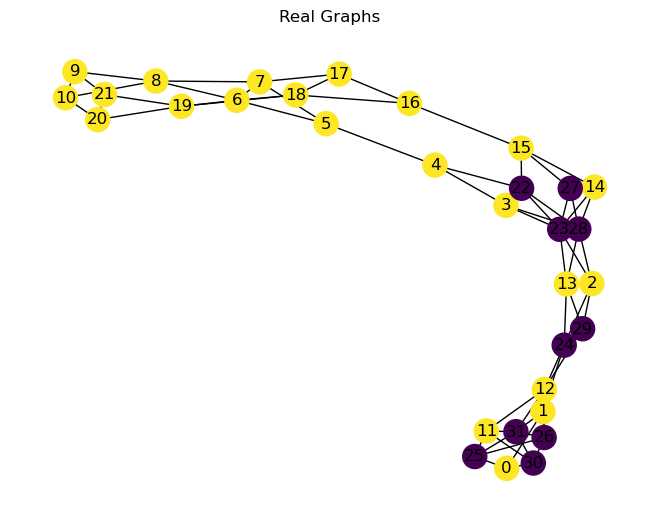

In [ ]:
#vis on real data
x = enz_dataset[0].x
edge_index = enz_dataset[0].edge_index

G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(edge_index.t().tolist())

nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Real Graphs')
plt.show()

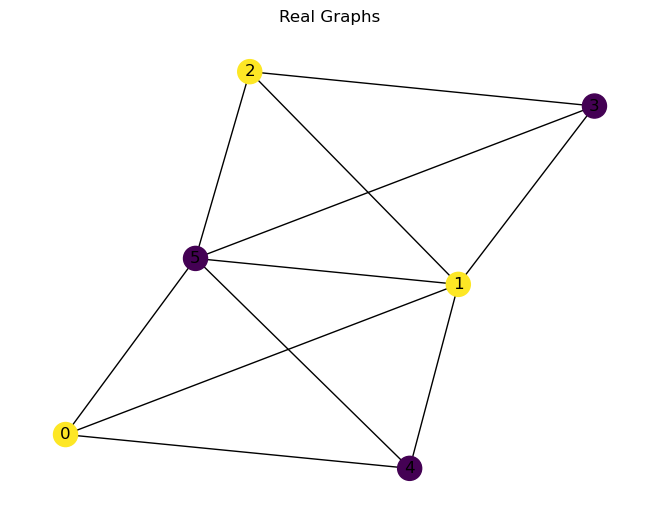

In [ ]:
#vis on real data
x = enz_dataset[13].x
edge_index = enz_dataset[13].edge_index

G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(edge_index.t().tolist())

nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Real Graphs')
plt.show()


In [ ]:
#simple graph classifier, achieve about 65% classification acc on this protein dataset
class simple_GAT_disc(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(simple_GAT_disc, self).__init__()
        torch.manual_seed(12345)
        hidden_channels=hidden_dim
        self.conv1 = GATConv(pro_dataset.num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, pro_dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gmp(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


In [ ]:
#SOTA classifier on this dataset, achieve about 75% classification acc
class ClassifierModel(torch.nn.Module):
    def __init__(self, args):
        super(ClassifierModel, self).__init__()
        self.args = args
        self.num_features = args.num_features
        self.nhid = args.nhid
        self.num_classes = args.num_classes
        self.pooling_ratio = args.pooling_ratio
        self.dropout_ratio = args.dropout_ratio
        self.sample = args.sample_neighbor
        self.sparse = args.sparse_attention
        self.sl = args.structure_learning
        self.lamb = args.lamb

        self.conv1 = GCNConv(self.num_features, self.nhid)
        self.conv2 = GCN(self.nhid, self.nhid)
        self.conv3 = GCN(self.nhid, self.nhid)

        self.pool1 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)
        self.pool2 = HGPSLPool(self.nhid, self.pooling_ratio, self.sample, self.sparse, self.sl, self.lamb)

        self.lin1 = torch.nn.Linear(self.nhid * 2, self.nhid)
        self.lin2 = torch.nn.Linear(self.nhid, self.nhid // 2)
        self.lin3 = torch.nn.Linear(self.nhid // 2, self.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = None

        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool1(x, edge_index, edge_attr, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x, edge_index, edge_attr, batch = self.pool2(x, edge_index, edge_attr, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(x1) + F.relu(x2) + F.relu(x3)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=self.dropout_ratio, training=self.training)
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x
     

In [ ]:
#params for SOTA model
num_node_features = pro_dataset.num_node_features
num_classes = pro_dataset.num_classes
class Args:
    def __init__(self, num_features, nhid, num_classes, pooling_ratio, dropout_ratio, sample_neighbor, sparse_attention, structure_learning, lamb):
        self.num_features = num_features
        self.nhid = nhid
        self.num_classes = num_classes
        self.pooling_ratio = pooling_ratio
        self.dropout_ratio = dropout_ratio
        self.sample_neighbor = sample_neighbor
        self.sparse_attention = sparse_attention
        self.structure_learning = structure_learning
        self.lamb = lamb

args = Args(
    num_features=num_node_features,
    nhid=64,
    num_classes=num_classes,
    pooling_ratio=0.5,
    dropout_ratio=0.5,
    sample_neighbor=False,
    sparse_attention=False,
    structure_learning=False,
    lamb=1.0
)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device='cuda'
#define z-generator: input node feature-like tensors(dim:(n,3), n: numberof nodes. 3 refers to dim of node feature in protein dataset)
#output: using DL to generate latent z representation. dim:(n,32)
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.layers =nn.Sequential()
        for i in range(10):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(0.1))
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self.topn = nn.Linear(hidden_dim, 1)
    """
    output: Z and n. 
    Z: generated fake latent representations. 
    n: threshold in decoder. Based on ranking of inner product of Z (decode process), deciding top n% of nodes connected
    """
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.layers(x)
        x = self.dropout(x)
        x_out = self.fc4(x)
        n = torch.mean(torch.sigmoid(self.topn(x)))
        return x_out, n
    

#generate random number of nodes based on stat distributions we've made above.
#this will generate a sample like: torch.tensor([a,b,c]). a: number of 1st kind of node, b: number of second kind of node. c: number of 3rd kind of node
def generate_from_real_dist(n_samples):
    means = torch.tensor([9, 12]) 
    stds = torch.tensor([11, 15])  
    samples_2 = torch.clamp(torch.normal(0, 1, size=(n_samples, 2)).mul(stds).add(means).abs().round().float(),min=1)
    mean=torch.tensor([0])
    std=torch.tensor([3])
    sample_3 = torch.clamp(torch.normal(0, 1, size=(n_samples, 1)).mul(std).add(mean).round().float(),min=0)
    sampl=torch.cat([samples_2,sample_3],dim=1)
    return sampl

#inner product decoder, for inner product of Z, top n% of node pairs will connect
def generate_edge_index(generator, samples):
    generated_features , tn= generator(samples)
    n_nodes = int(torch.sum(samples))
    indices = torch.stack([torch.arange(n_nodes), torch.arange(n_nodes)], dim=1)
    indices = torch.cat([indices[i:i+1] for i in range(n_nodes)], dim=0)
    edge_features = torch.matmul(generated_features[indices[:, 0]], generated_features[indices[:, 1]].T)
    n = int(edge_features.numel() * tn)
    threshold=torch.kthvalue(edge_features.view(-1), edge_features.numel() - n).values
    index=torch.cat((list(torch.where(edge_features>threshold))[0].unsqueeze(1),list(torch.where(edge_features>threshold))[1].unsqueeze(1)),dim=-1)
    pairs = index[index[:, 0] != index[:, 1]]
    return pairs.T

#generate fake dataset. including fake node feature and fake edge index for graphs
def generate_datasets(generator, n_samples):
    samples = generate_from_real_dist(n_samples)
    generated_dataset=[]
    for s in samples:
        tensor_list=[]
        for n in range(3):
            tensor_list.extend([[1,0,0] if n==0 else [0,1,0] if n==1 else [0,0,1] for i in range(int(s[n]))])
        torch_input=torch.tensor(tensor_list,dtype=torch.float).to(device)
        edge_index = generate_edge_index(generator.to(device), torch_input)
        generated_dataset.append(Data(x=torch_input,edge_index=edge_index))
    return generated_dataset


#generated fake graphs
print(generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),32))


[Data(x=[28, 3], edge_index=[2, 350]), Data(x=[41, 3], edge_index=[2, 758]), Data(x=[63, 3], edge_index=[2, 1812]), Data(x=[14, 3], edge_index=[2, 84]), Data(x=[43, 3], edge_index=[2, 836]), Data(x=[35, 3], edge_index=[2, 554]), Data(x=[47, 3], edge_index=[2, 1002]), Data(x=[16, 3], edge_index=[2, 110]), Data(x=[48, 3], edge_index=[2, 1040]), Data(x=[52, 3], edge_index=[2, 1232]), Data(x=[50, 3], edge_index=[2, 1136]), Data(x=[36, 3], edge_index=[2, 584]), Data(x=[33, 3], edge_index=[2, 490]), Data(x=[16, 3], edge_index=[2, 110]), Data(x=[26, 3], edge_index=[2, 300]), Data(x=[48, 3], edge_index=[2, 1046]), Data(x=[24, 3], edge_index=[2, 256]), Data(x=[16, 3], edge_index=[2, 110]), Data(x=[51, 3], edge_index=[2, 1184]), Data(x=[57, 3], edge_index=[2, 1482]), Data(x=[43, 3], edge_index=[2, 840]), Data(x=[17, 3], edge_index=[2, 124]), Data(x=[15, 3], edge_index=[2, 96]), Data(x=[10, 3], edge_index=[2, 40]), Data(x=[11, 3], edge_index=[2, 50]), Data(x=[22, 3], edge_index=[2, 214]), Data(x=

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 100
# Batch size to use
BATCHLEN = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train_gan(TRAIN_RATIO=1,N_ITER = 20000,BATCHLEN = 8, lr=1e-6, generate_ratro=2) :
    pro_dataset=TUDataset(root="/",name='PROTEINS')
    enz_dataset = pro_dataset[[i for i in range(len(pro_dataset)) if pro_dataset[i].y == 1]]
    generator = Generator(input_dim=3, hidden_dim=64, output_dim=32).to(device)
    optim_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.9))
    """
    here I chose simple classifier to better converge
    """
#     discriminator = ClassifierModel(args).to(device)
    discriminator = simple_GAT_disc(hidden_dim=256).to(device)
    optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

    for i in range(N_ITER):
    # train the discriminator
        real_dataloader=DataLoader(enz_dataset[:BATCHLEN*TRAIN_RATIO], batch_size=BATCHLEN, shuffle=True,drop_last=True)
        fake_dataloader=DataLoader(generate_datasets(generator,BATCHLEN*TRAIN_RATIO), batch_size=BATCHLEN,drop_last=True)
        for r_data, f_data in zip(real_dataloader, fake_dataloader):
            real_outputs = discriminator(r_data.to(device))
            fake_outputs = discriminator(f_data.to(device))
            disc_loss = F.softplus(-real_outputs) + F.softplus(fake_outputs)
            disc_loss = disc_loss.mean()
            disc_loss.backward()
            optim_disc.step()
            
        # train the generator
        generator.zero_grad()
        fake_dataloader=DataLoader(generate_datasets(generator,BATCHLEN*generate_ratro), batch_size=BATCHLEN, shuffle=True)
        for f_data in fake_dataloader:
            fake_outputs = discriminator(f_data.to(device))
            gen_loss = F.softplus(-fake_outputs)
            gen_loss = gen_loss.mean() 
            gen_loss.backward()
            optim_gen.step()
        if i%100 == 0:
            print(f'step {i}: discriminator: {round(float(disc_loss),5)}, generator: {round(float(gen_loss),5)}')
  
    print("After training for {} iteration : discriminator: {:.3e}, generator: {:.3e}".format(N_ITER, float(disc_loss), float(gen_loss)))
train_gan()

step 0: discriminator: 1.3821, generator: 0.69441
step 100: discriminator: 1.30688, generator: 0.41416
step 200: discriminator: 1.54208, generator: 0.31083
step 300: discriminator: 1.47769, generator: 0.5439
step 400: discriminator: 1.33501, generator: 0.37218
step 500: discriminator: 1.52315, generator: 0.35113
step 600: discriminator: 1.609, generator: 0.33941
step 700: discriminator: 1.71269, generator: 0.3209
step 800: discriminator: 1.50783, generator: 0.33985
step 900: discriminator: 1.67317, generator: 0.28061
step 1000: discriminator: 1.37072, generator: 0.34705
step 1100: discriminator: 1.75779, generator: 0.27128
step 1200: discriminator: 1.64344, generator: 0.38571
step 1300: discriminator: 1.80256, generator: 0.37038
step 1400: discriminator: 1.75054, generator: 0.27541
step 1500: discriminator: 1.79557, generator: 0.42076
step 1600: discriminator: 2.11021, generator: 0.24378
step 1700: discriminator: 1.49815, generator: 0.24052
step 1800: discriminator: 1.63483, generator:

step 15200: discriminator: 2.00798, generator: 0.18725
step 15300: discriminator: 2.16193, generator: 0.30544
step 15400: discriminator: 2.33948, generator: 0.21868
step 15500: discriminator: 2.79156, generator: 0.57491
step 15600: discriminator: 2.81648, generator: 0.24693
step 15700: discriminator: 2.15789, generator: 0.37366
step 15800: discriminator: 1.49935, generator: 0.26455
step 15900: discriminator: 2.59228, generator: 0.44258
step 16000: discriminator: 2.54709, generator: 0.61009
step 16100: discriminator: 2.2612, generator: 0.26536
step 16200: discriminator: 2.4754, generator: 0.59312
step 16300: discriminator: 2.54369, generator: 0.35091
step 16400: discriminator: 2.35942, generator: 0.31297
step 16500: discriminator: 2.17895, generator: 0.35904
step 16600: discriminator: 2.53394, generator: 0.45759
step 16700: discriminator: 2.88255, generator: 0.57533
step 16800: discriminator: 1.70708, generator: 0.27678
step 16900: discriminator: 2.04996, generator: 0.61453
step 17000: 

In [ ]:
#save model
torch.save(generator.state_dict(), f'generator.pth' )

# Visualizations

## Generated data from untrained model

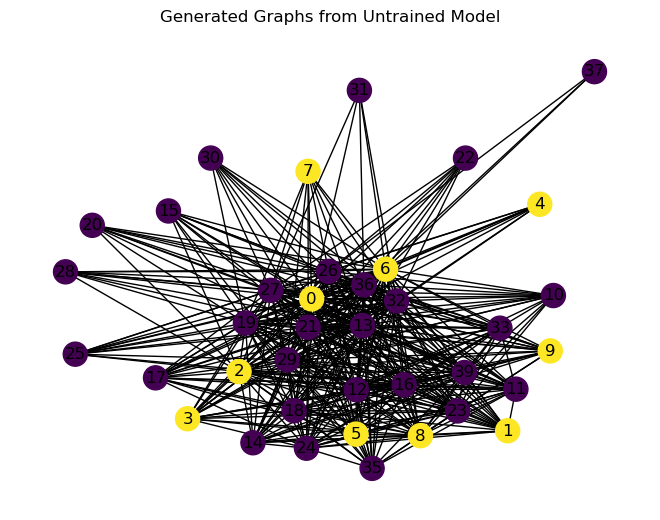

In [ ]:
import networkx as nx
#untrained fake data
generator = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
generated_graph=generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),1)
x = generated_graph[0].x
ei = generated_graph[0].edge_index
G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(ei.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
x = np.delete(x.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Generated Graphs from Untrained Model')
plt.show()


## Generated data from trained model

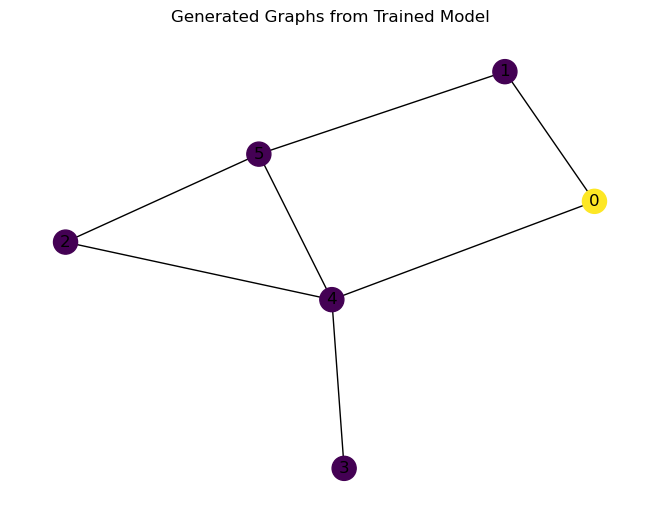

In [ ]:
generator = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),1)
x = generated_graph[0].x
ei = generated_graph[0].edge_index
G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(ei.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
x = np.delete(x.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Generated Graphs from Trained Model')
plt.show()

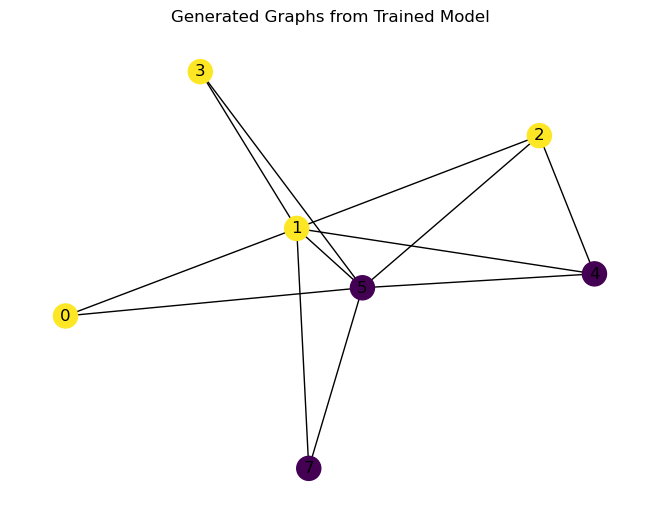

In [ ]:
generator = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),1)
x = generated_graph[0].x
ei = generated_graph[0].edge_index
G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(ei.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
x = np.delete(x.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Generated Graphs from Trained Model')
plt.show()

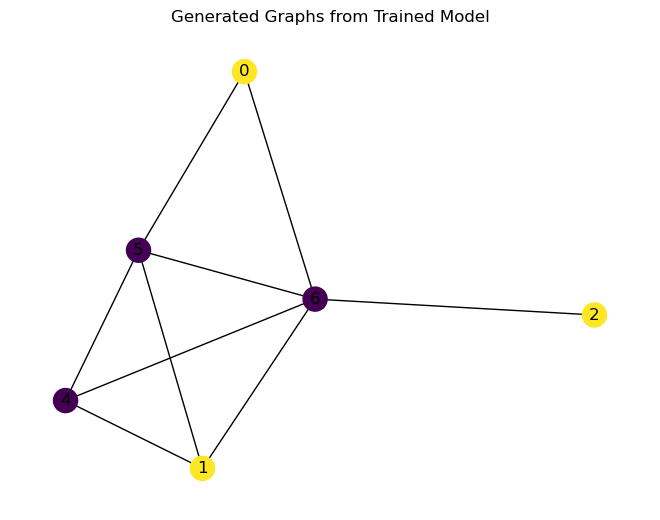

In [ ]:
generator = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),1)
x = generated_graph[0].x
ei = generated_graph[0].edge_index
G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(ei.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
x = np.delete(x.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Generated Graphs from Trained Model')
plt.show()

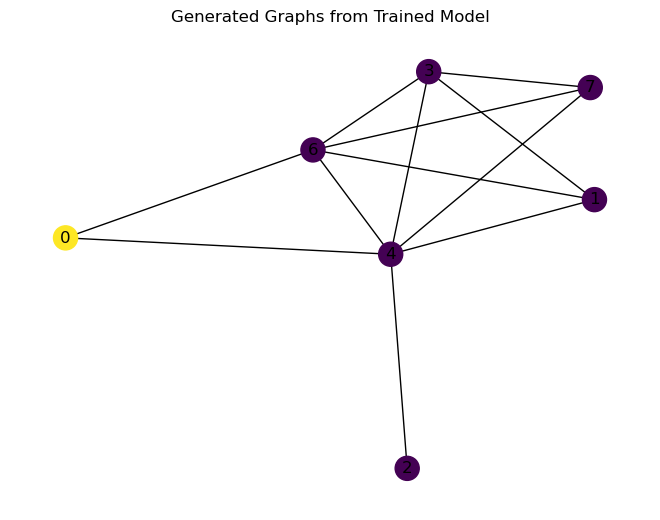

In [ ]:
generator = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
generator.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(Generator(input_dim=3, hidden_dim=64, output_dim=8),1)

x = generated_graph[0].x
ei = generated_graph[0].edge_index

G = nx.Graph()
G.add_nodes_from(range(x.size(0)))
G.add_edges_from(ei.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
x = np.delete(x.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=x[:, 0], with_labels=True)
plt.title('Generated Graphs from Trained Model')
plt.show()

From those graphs we can see that even if GAN is not working very well, some graphs from trained generator is trying to capture features from real enzyme data.

# Evaluate with SOTA model

In [ ]:
from sklearn.model_selection import train_test_split
model = ClassifierModel(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
best_performance = torch.load('model_hgpsl_pool.pt')
model.load_state_dict(best_performance)

<All keys matched successfully>

# GAN trained generator performance

In [ ]:
#load untrained generator. Generate 1000 examples load into dataloader
gen = Generator(input_dim=3, hidden_dim=128, output_dim=32).to(device)
gen.load_state_dict(torch.load("generator.pth", map_location='cpu'))
generated_graph=generate_datasets(gen,1000)
test_loader = DataLoader(generated_graph, batch_size=10, shuffle=False)
#SOTA model evaluate on generated graphs
model.eval()
ones = 0
for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
    pred = out.argmax(dim=1)
    ones += (pred).sum().item()
print(f"Percentage of generated graphs recognized as enzymes by SOTA classifier on protein dataset: {ones/10}%")

Percentage of generated graphs recognized as enzymes by SOTA classifier on protein dataset: 51.6%
